In [1]:
import warnings
warnings.filterwarnings('ignore')
import os
os.environ['PROJ_LIB'] = r'C:/Users/mastr/miniconda3/pkgs/proj4-5.2.0-ha925a31_1/Library/share'     ## Windows OS
# os.environ['PROJ_LIB'] = r'/Users/mmastro/miniconda3/pkgs/proj4-5.2.0-ha925a31_1/Library/share'     ## Mac OS
import glob
import netCDF4 as nc
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import cartopy as cart
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.mpl.ticker as cticker

import geopandas as gpd
from importlib.machinery import SourceFileLoader
# imports the module from the given path
gpd = SourceFileLoader("geopandas","C:/Users/mastr/miniconda3/pkgs/geopandas-0.7.0-py_1/site-packages/geopandas/__init__.py").load_module()
from clisops.ops.subset import subset

In [2]:
## Function for moving average ##
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

## -- Function for get strings of dates in .nc input files -- ##
def set_string_time(file, tname):
    nctime = file.variables[tname][:] # get values
    t_unit = file.variables[tname].units # get unit  "days since 1950-01-01T00:00:00Z"
    t_cal = file.variables[tname].calendar
    tvalue = nc.num2date(nctime,units = t_unit,calendar = t_cal)
    str_time = [i.strftime("%Y-%m") for i in tvalue]
    str_timey = [i.strftime("%Y") for i in tvalue]
    str_timem = [i.strftime("%m") for i in tvalue]
    return [str_time, str_timey, str_timem]

## Function for creating a path, if needed ##
def checkDir(out_path):
    if not os.path.exists(out_path):
        os.makedirs(out_path)

def cell_weight(ds):
    R = 6.371e6
    dϕ = np.deg2rad(ds.lat[1] - ds.lat[0])
    dλ = np.deg2rad(ds.lon[1] - ds.lon[0])
    dlat = R * dϕ * xr.ones_like(ds.lon)
    dlon = R * dλ * np.cos(np.deg2rad(ds.lat))
    cell_area = dlon * dlat
    return(cell_area)

def detrend_dim(da, dim, degree):
    # detrend along a single dimension
    p = da.polyfit(dim=dim, deg=degree)
    fit = xr.polyval(da[dim], p.polyfit_coefficients)
    da_det = (da - fit)
    return da_det

In [3]:
# -- Path for netcdf files

data_path = 'F:/Data/analysis/'               ## HDEXT
# data_path = 'C:/Users/mastr/Documents/Amazon/ENSO'     # PC

# -- Path for the output files (images, etc)
# out_path = "D:/Data/CMIP6/ENSO"      ## HDEXT
out_path = 'C:/Users/mastr/Documents/Amazon/ENSO_detrended'

# -- Create directories
checkDir(data_path)
checkDir(out_path)

# esm = ["ACCESS-ESM1-5", "BCC-CSM2-MR", "CESM2-WACCM", "CMCC-ESM2", "CNRM-ESM2-1", "CanESM5",  "E3SM-1-1-ECA", "IPSL-CM6A-LR", "MIROC-ES2L", "MPI-ESM1-2-LR", "NorESM2-MM", "TaiESM1", "UKESM1-0-LL"]
esm = ["ACCESS-ESM1-5", "CanESM5", "CNRM-ESM2-1", "MIROC-ES2L", "MRI-ESM2-0", "NorESM2-LM", "UKESM1-0-LL"]
esm = ["MRI-ESM2-0", "NorESM2-LM"]

In [4]:
# Data preprocessing

# for i, item in enumerate(DS_models):
#     if item.lon[0] == 0.5:
#         #DS_models[i] = DS_models[i].roll(lon = 180, roll_coords=False)                              # Roll by 180 steps to 0 360
#         DS_models[i] = item.assign_coords(lon=(DS_models[i].lon - 0.5)); 

In [5]:
##### ------- Open data (MODEL) ------- #####
data_path = 'F:/Data/analysis/'              
var_name = 'tos'

scenario = 'historical'
files = var_name + '_*_' + scenario + '_*_' + 'remap.nc'

files_list = []
for filepath in sorted(glob.glob(os.path.join(data_path+scenario+"/"+files))):               # List of files sorted by name
        content = nc.Dataset(filepath)
        files_list.append(content)   

ds_hist = []
for filepath in sorted(glob.glob(os.path.join(data_path+scenario+"/"+var_name + '_*_' + scenario + '_*_' + 'remap.nc'))):               # sorted is case sensitive                             ## List of files sorted by name
    content = xr.open_dataset(filepath, drop_variables=["time_bnds","lon_bnds","lat_bnds"]); #content = content.mean(dim="time")         ## values   var     dims    coords
    ds_hist.append(content)

scenario = 'ssp585'
files = var_name + '_*_' + scenario + '_*_' + 'remap.nc'  

ds_ssp = []
for filepath in sorted(glob.glob(os.path.join(data_path+scenario+"/"+var_name + '_*_' + scenario + '_*_' + 'remap.nc'))):               # sorted is case sensitive                             ## List of files sorted by name
    content = xr.open_dataset(filepath, drop_variables=["time_bnds","lon_bnds","lat_bnds"]); #content = content.mean(dim="time")         ## values   var     dims    coords
    ds_ssp.append(content)

# # Control for CALENDAR: convert cftime.datetime to np.datetime64
for i, item in enumerate(ds_hist):
    if item['time'].dt.calendar == 'noleap' or item['time'].dt.calendar == '360_day':
        ds_hist[i]['time'] = item.indexes['time'].to_datetimeindex()
    
# # Control for CALENDAR: convert cftime.datetime to np.datetime64
for i, item in enumerate(ds_ssp):
    if item['time'].dt.calendar == 'noleap' or item['time'].dt.calendar == '360_day':
        ds_ssp[i]['time'] = item.indexes['time'].to_datetimeindex()

In [6]:
cell_area_hist = [cell_weight(a) for a in ds_hist]
cell_area_ssp = [cell_weight(a) for a in ds_ssp]

### Nino 3.4 index

In [7]:
# Nino 3.4 with 5 month running mean

nino34_hist = []
for i, item in enumerate(ds_hist):
    content = (item.sel(lat = slice(-5, 5), lon = slice(190, 240)).weighted(cell_area_hist[i]).mean(["lat", "lon"]).groupby('time.month') - 
    item.sel(lat = slice(-5, 5), lon = slice(190, 240)).sel(time= slice("1981-01", "2010-12")).groupby('time.month').mean('time').weighted(cell_area_hist[i]).mean(["lat", "lon"])).compute(dim=var_name).rolling(time = 5, center = True).mean()
    nino34_hist.append(content)

nino34_ssp = []
for i, item in enumerate(ds_ssp):
    content = (item.sel(lat = slice(-5, 5), lon = slice(190, 240)).weighted(cell_area_ssp[i]).mean(["lat", "lon"]).groupby('time.month') - 
    ds_hist[i].sel(lat = slice(-5, 5), lon = slice(190, 240)).sel(time= slice("1981-01", "2010-12")).groupby('time.month').mean('time').weighted(cell_area_hist[i]).mean(["lat", "lon"])).compute(dim=var_name).rolling(time = 5, center = True).mean()
    nino34_ssp.append(content)

In [8]:
# 1st order detrending (linear) 

nino34_hist_det = []
for i, item in enumerate(nino34_hist):
    content = detrend_dim(nino34_hist[i][var_name], "time", 1)
    nino34_hist_det.append(content)

nino34_ssp_det = []
for i, item in enumerate(nino34_ssp):
    content = detrend_dim(nino34_ssp[i][var_name], "time", 1)
    nino34_ssp_det.append(content)

Text(0.5, 1.0, 'NINO3.4')

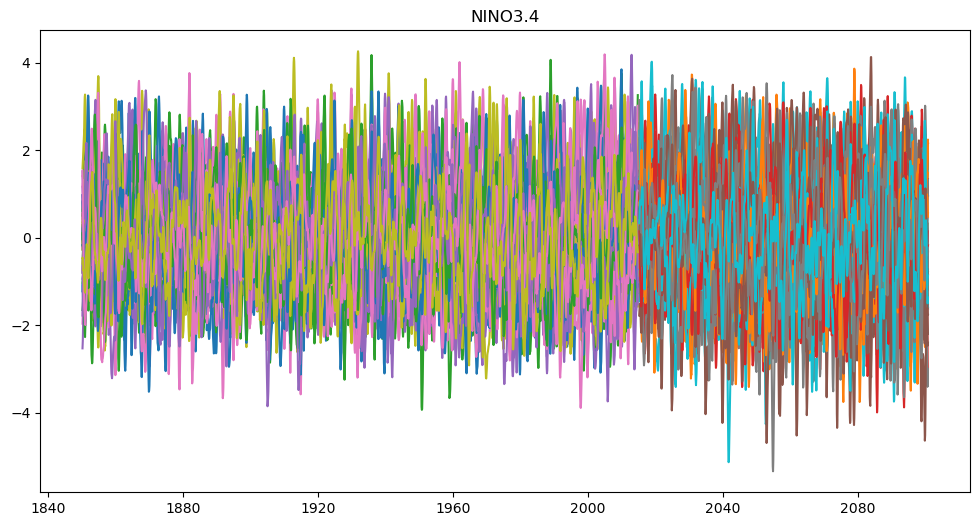

In [9]:
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(12, 6)) #, constrained_layout=True)

for i, item in enumerate(ds_ssp):
    axs.plot(nino34_hist[i]['time'],nino34_hist_det[i])
    axs.plot(nino34_ssp[i]['time'],nino34_ssp_det[i])


axs.set_title("NINO3.4")


In [11]:
out_path = 'C:/Users/mastr/Documents/Amazon/ENSO_detrended'

# -- Export files 
for i,item in enumerate(ds_ssp):
    nino34_hist[i].to_netcdf(os.path.join(out_path+"/nino34_"+item.source_id+"_"+"historical"+"_"+item.variant_label+".nc"))
    nino34_ssp[i].to_netcdf(os.path.join(out_path+"/nino34_"+item.source_id+"_"+"ssp585"+"_"+item.variant_label+".nc"))
 
    

In [12]:
os.path.join(out_path+"/nino34_"+item.source_id+"_"+"historical"+"_"+item.variant_label+".nc")

'C:/Users/mastr/Documents/Amazon/ENSO_detrended/nino34_UKESM1-0-LL_historical_r8i1p1f2.nc'

### TNA index

In [28]:
# TNA index

tna_hist = []
for i, item in enumerate(ds_hist):
    content = (item.sel(lat = slice(5,25), lon = slice(305,345)).weighted(cell_area_hist[i]).mean(["lat", "lon"]).groupby('time.month') - 
    item.sel(lat = slice(5,25), lon = slice(305,345)).sel(time= slice("1981-01", "2010-12")).groupby('time.month').mean('time').weighted(cell_area_hist[i]).mean(["lat", "lon"])).compute(dim=var_name).rolling(time = 5, center = True).mean()
    tna_hist.append(content)

tna_ssp = []
for i, item in enumerate(ds_ssp):
    content = (item.sel(lat = slice(5,25), lon = slice(305,345)).weighted(cell_area_ssp[i]).mean(["lat", "lon"]).groupby('time.month') - 
    ds_hist[i].sel(lat = slice(5,25), lon = slice(305,345)).sel(time= slice("1981-01", "2010-12")).groupby('time.month').mean('time').weighted(cell_area_hist[i]).mean(["lat", "lon"])).compute(dim=var_name).rolling(time = 5, center = True).mean()
    tna_ssp.append(content)

In [152]:
# 1st order detrending (linear) 

tna_hist_det = []
for i, item in enumerate(tna_hist):
    content = detrend_dim(tna_hist[i][var_name], "time", 3)
    tna_hist_det.append(content)

tna_ssp_det = []
for i, item in enumerate(tna_ssp):
    content = detrend_dim(tna_ssp[i][var_name], "time", 3)
    tna_ssp_det.append(content)

Text(0.5, 1.0, 'TNA')

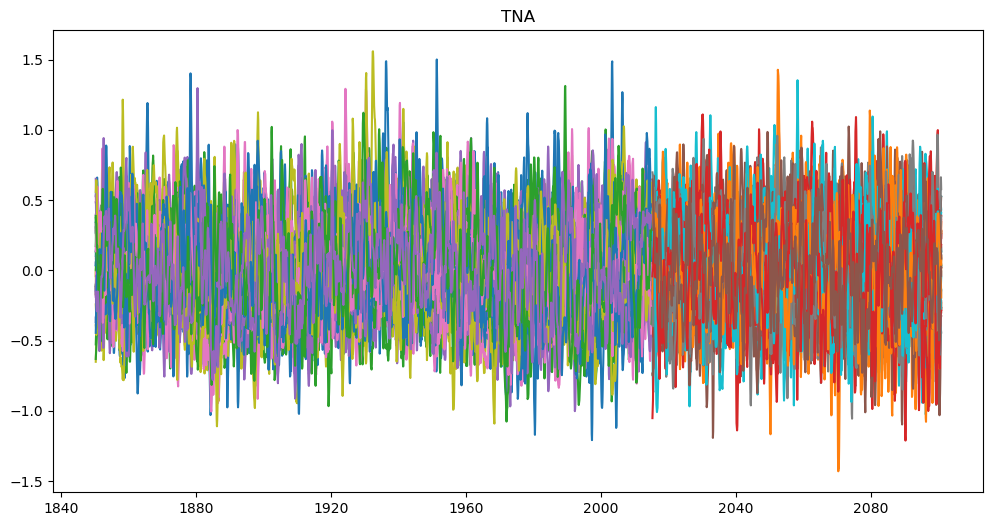

In [140]:
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(12, 6)) #, constrained_layout=True)

for i, item in enumerate(ds_ssp):
    axs.plot(tna_hist_det[i]['time'],tna_hist_det[i])
    axs.plot(tna_ssp_det[i]['time'],tna_ssp_det[i])


axs.set_title("TNA")


In [153]:
# Export files 
for i,item in enumerate(ds_ssp):
    tna_hist_det[i].to_netcdf(os.path.join(out_path+"/tna_"+item.source_id+"_"+"historical"+"_"+item.variant_label+".nc"))
    tna_ssp_det[i].to_netcdf(os.path.join(out_path+"/tna_"+item.source_id+"_"+"ssp585"+"_"+item.variant_label+".nc"))

### TSA index

In [24]:
# TSA with subset from clisops

tsa_hist = []
for i, item in enumerate(ds_hist):
    content = (subset(ds=item, area=(-30, -20, 10, 0), output_type="xarray")[0].weighted(cell_area_hist[i]).mean(["lat", "lon"]).groupby('time.month') - 
    subset(ds=item, area=(-30, -20, 10, 0), output_type="xarray")[0].sel(time= slice("1981-01", "2010-12")).groupby('time.month').mean('time').weighted(cell_area_hist[i]).mean(["lat", "lon"])).compute(dim=var_name)
    tsa_hist.append(content)

tsa_ssp = []
for i, item in enumerate(ds_ssp):
    content = (subset(ds=item, area=(-30, -20, 10, 0), output_type="xarray")[0].weighted(cell_area_ssp[i]).mean(["lat", "lon"]).groupby('time.month') - 
    subset(ds=ds_hist[i], area=(-30, -20, 10, 0), output_type="xarray")[0].sel(time= slice("1981-01", "2010-12")).groupby('time.month').mean('time').weighted(cell_area_hist[i]).mean(["lat", "lon"])).compute(dim=var_name)
    tsa_ssp.append(content)

2023-04-26 14:58:15,756 - c:\Users\mastr\miniconda3\envs\geo_clim\lib\site-packages\clisops\ops\base_operation.py - INFO - Processing Subset for times: ('1850-01-16', '2014-12-16')
2023-04-26 14:58:15,756 - c:\Users\mastr\miniconda3\envs\geo_clim\lib\site-packages\clisops\utils\output_utils.py - INFO - format_writer=None, output_type=xarray
2023-04-26 14:58:15,756 - c:\Users\mastr\miniconda3\envs\geo_clim\lib\site-packages\clisops\utils\output_utils.py - INFO - Returning output as <class 'xarray.core.dataset.Dataset'>
2023-04-26 14:58:17,971 - c:\Users\mastr\miniconda3\envs\geo_clim\lib\site-packages\clisops\ops\base_operation.py - INFO - Processing Subset for times: ('1850-01-16', '2014-12-16')
2023-04-26 14:58:17,979 - c:\Users\mastr\miniconda3\envs\geo_clim\lib\site-packages\clisops\utils\output_utils.py - INFO - format_writer=None, output_type=xarray
2023-04-26 14:58:17,979 - c:\Users\mastr\miniconda3\envs\geo_clim\lib\site-packages\clisops\utils\output_utils.py - INFO - Returning 

In [150]:
# 1st order detrending (linear) 

tsa_hist_det = []
for i, item in enumerate(tsa_hist):
    content = detrend_dim(tsa_hist[i][var_name], "time", 3)
    tsa_hist_det.append(content)

tsa_ssp_det = []
for i, item in enumerate(tsa_ssp):
    content = detrend_dim(tsa_ssp[i][var_name], "time", 3)
    tsa_ssp_det.append(content)

Text(0.5, 1.0, 'TSA')

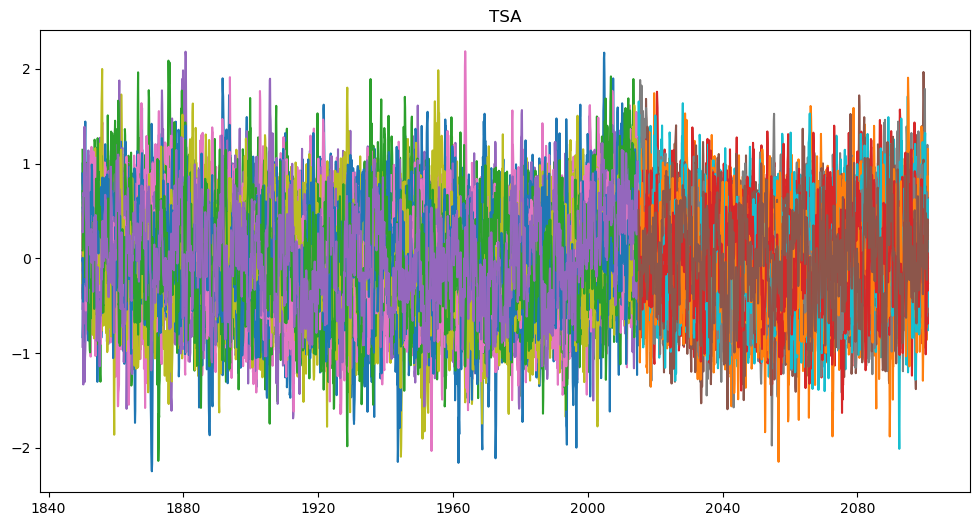

In [26]:
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(12, 6)) #, constrained_layout=True)

for i, item in enumerate(ds_ssp):
    axs.plot(tsa_hist_det[i]['time'],tsa_hist_det[i])
    axs.plot(tsa_ssp_det[i]['time'],tsa_ssp_det[i])


axs.set_title("TSA")


In [151]:
# -- Export files 
for i,item in enumerate(ds_ssp):
    tsa_hist_det[i].to_netcdf(os.path.join(out_path+"/tsa_"+item.source_id+"_"+"historical"+"_"+item.variant_label+".nc"))
    tsa_ssp_det[i].to_netcdf(os.path.join(out_path+"/tsa_"+item.source_id+"_"+"ssp585"+"_"+item.variant_label+".nc"))